## 1. Setup and Data Loading


In [2]:
import polars as pl
import sys
from pathlib import Path
import numpy as np

sys.path.insert(0, str(Path.cwd().parent / "src"))

from conf import get_database_url

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [20]:
# Get database connection string
db_url = get_database_url(make_ipv6_in_bracket=True)

events = pl.read_database_uri("SELECT * FROM events", db_url)
teams = pl.read_database_uri("SELECT * FROM teams", db_url)
players = pl.read_database_uri("SELECT * FROM players", db_url)
matches = pl.read_database_uri("SELECT * FROM matches", db_url)
non_top_events_matches = pl.read_database_uri(
    "SELECT M.* FROM matches M INNER JOIN events E ON M.event_id = E.event_id and E.has_top_50_teams is false",
    db_url,
)
top_events_matches = pl.read_database_uri(
    "SELECT M.* FROM matches M INNER JOIN events E ON M.event_id = E.event_id and E.has_top_50_teams is true",
    db_url,
)
vetos = pl.read_database_uri("SELECT * FROM vetos", db_url)
non_top_event_vetos = pl.read_database_uri(
    """
    SELECT V.* FROM vetos V
    INNER JOIN matches M ON V.match_id = M.match_id
    INNER JOIN events E ON M.event_id = E.event_id
    WHERE E.has_top_50_teams is false
""",
    db_url,
)
top_event_vetos = pl.read_database_uri(
    """
    SELECT V.* FROM vetos V
    INNER JOIN matches M ON V.match_id = M.match_id
    INNER JOIN events E ON M.event_id = E.event_id
    WHERE E.has_top_50_teams is true
""",
    db_url,
)
map_stats = pl.read_database_uri("SELECT * FROM map_stats", db_url)
non_top_event_map_stats = pl.read_database_uri(
    """
    SELECT MS.* FROM map_stats MS
    INNER JOIN matches M ON MS.match_id = M.match_id
    INNER JOIN events E ON M.event_id = E.event_id
    WHERE E.has_top_50_teams is false
""",
    db_url,
)
top_event_map_stats = pl.read_database_uri(
    """
    SELECT MS.* FROM map_stats MS
    INNER JOIN matches M ON MS.match_id = M.match_id
    INNER JOIN events E ON M.event_id = E.event_id
    WHERE E.has_top_50_teams is true
""",
    db_url,
)
player_map_stats = pl.read_database_uri("SELECT * FROM player_map_stats", db_url)
top_events_player_map_stats = pl.read_database_uri(
    """
    SELECT PMS.* FROM player_map_stats PMS
    INNER JOIN map_stats M ON PMS.map_stat_id = M.map_stat_id
    INNER JOIN matches M2 ON M.match_id = M2.match_id
    INNER JOIN events E ON M2.event_id = E.event_id
    WHERE E.has_top_50_teams is true
""",
    db_url,
)

print(f"Events: {len(events)} rows")
print(f"Teams: {len(teams)} rows")
print(f"Players: {len(players)} rows")
print(f"Matches: {len(matches)} rows")
print(f"Top Events Matches: {len(top_events_matches)} rows")
print(f"Vetos: {len(vetos)} rows")
print(f"Top Event Vetos: {len(top_event_vetos)} rows")
print(f"Map Stats: {len(map_stats)} rows")
print(f"Top Event Map Stats: {len(top_event_map_stats)} rows")
print(f"Player Map Stats: {len(player_map_stats)} rows")
print(f"Top Events Player Map Stats: {len(top_events_player_map_stats)} rows")

Events: 1378 rows
Teams: 1529 rows
Players: 4998 rows
Matches: 20309 rows
Top Events Matches: 11755 rows
Vetos: 20309 rows
Top Event Vetos: 11755 rows
Map Stats: 43342 rows
Top Event Map Stats: 24637 rows
Player Map Stats: 430689 rows
Top Events Player Map Stats: 245291 rows


## 2. Data Overview and Basic Statistics


In [4]:
print("=== EVENTS ===")
print(events.head())
print(f"\nShape: {events.shape}")
print(f"\nSchema:\n{events.schema}")


=== EVENTS ===
shape: (5, 13)
┌──────────┬────────────┬───────────┬───────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ event_id ┆ name       ┆ start_dat ┆ end_date  ┆ … ┆ player_sh ┆ location ┆ event_typ ┆ has_top_5 │
│ ---      ┆ ---        ┆ e         ┆ ---       ┆   ┆ are       ┆ ---      ┆ e         ┆ 0_teams   │
│ i32      ┆ str        ┆ ---       ┆ datetime[ ┆   ┆ ---       ┆ str      ┆ ---       ┆ ---       │
│          ┆            ┆ datetime[ ┆ μs, UTC]  ┆   ┆ decimal[3 ┆          ┆ str       ┆ bool      │
│          ┆            ┆ μs, UTC]  ┆           ┆   ┆ 8,10]     ┆          ┆           ┆           │
╞══════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ 8890     ┆ ZOWIE eXTR ┆ null      ┆ null      ┆ … ┆ null      ┆ null     ┆ null      ┆ false     │
│          ┆ EMESLAND   ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
│          ┆ Asia Open  ┆           ┆           ┆   ┆        

In [5]:
print("\n\n=== TEAMS ===")
print(teams.head())
print(f"\nShape: {teams.shape}")
print(f"Schema:\n{teams.schema}")



=== TEAMS ===
shape: (5, 2)
┌─────────┬─────────────────┐
│ team_id ┆ name            │
│ ---     ┆ ---             │
│ i32     ┆ str             │
╞═════════╪═════════════════╡
│ 8068    ┆ AGO             │
│ 12102   ┆ Stirlzs Angels  │
│ 8248    ┆ PACT            │
│ 12528   ┆ Hyper5          │
│ 12532   ┆ upcoming galimi │
└─────────┴─────────────────┘

Shape: (1529, 2)
Schema:
Schema({'team_id': Int32, 'name': String})


In [6]:
print("=== PLAYERS ===")
print(players.head(10))
print(f"\nTotal players: {len(players)}")
print(f"\nSchema:\n{players.schema}")

=== PLAYERS ===
shape: (10, 2)
┌───────────┬──────────┐
│ player_id ┆ name     │
│ ---       ┆ ---      │
│ i32       ┆ str      │
╞═══════════╪══════════╡
│ 23600     ┆ Alkaren  │
│ 19187     ┆ xfl0ud   │
│ 20119     ┆ nilo     │
│ 19310     ┆ LNZ      │
│ 22047     ┆ yxngstxr │
│ 25394     ┆ lzj      │
│ 25453     ┆ tidy     │
│ 22978     ┆ Arctic   │
│ 21855     ┆ neo      │
│ 24077     ┆ FincHY   │
└───────────┴──────────┘

Total players: 4998

Schema:
Schema({'player_id': Int32, 'name': String})


In [7]:
print("\n\n=== MATCHES ===")
print(matches.head())
print(f"\nShape: {matches.shape}")
print(f"\nSchema:\n{matches.schema}")
print(
    f"\nMatch date range: {matches['match_date'].min()} to {matches['match_date'].max()}"
)



=== MATCHES ===
shape: (5, 8)
┌──────────┬──────────┬─────────────┬───────────┬───────────┬────────────┬────────────┬────────────┐
│ match_id ┆ event_id ┆ match_date  ┆ team_1_id ┆ team_2_id ┆ team_1_map ┆ team_2_map ┆ team_winne │
│ ---      ┆ ---      ┆ ---         ┆ ---       ┆ ---       ┆ _score     ┆ _score     ┆ r_id       │
│ i32      ┆ i32      ┆ datetime[μs ┆ i32       ┆ i32       ┆ ---        ┆ ---        ┆ ---        │
│          ┆          ┆ , UTC]      ┆           ┆           ┆ i32        ┆ i32        ┆ i32        │
╞══════════╪══════════╪═════════════╪═══════════╪═══════════╪════════════╪════════════╪════════════╡
│ 2387716  ┆ 8827     ┆ 2025-11-06  ┆ 13515     ┆ 13516     ┆ 1          ┆ 2          ┆ 13516      │
│          ┆          ┆ 10:30:00    ┆           ┆           ┆            ┆            ┆            │
│          ┆          ┆ UTC         ┆           ┆           ┆            ┆            ┆            │
│ 2387724  ┆ 8824     ┆ 2025-11-06  ┆ 9455      ┆ 13471    

In [17]:
print("\n\n=== Vetos ===")
print(vetos.head())
print(f"\nShape: {vetos.shape}")
print(f"\nSchema:\n{vetos.schema}")



=== Vetos ===
shape: (5, 13)
┌──────────┬─────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ match_id ┆ best_of ┆ t1_removed ┆ t2_removed ┆ … ┆ t2_picked ┆ t1_remove ┆ t2_remove ┆ left_over │
│ ---      ┆ ---     ┆ _1         ┆ _1         ┆   ┆ _2        ┆ d_3       ┆ d_3       ┆ _map      │
│ i32      ┆ i32     ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆         ┆ str        ┆ str        ┆   ┆ str       ┆ str       ┆ str       ┆ str       │
╞══════════╪═════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2387020  ┆ 3       ┆ Mirage     ┆ Ancient    ┆ … ┆ null      ┆ null      ┆ null      ┆ Overpass  │
│ 2387649  ┆ 3       ┆ Inferno    ┆ Train      ┆ … ┆ null      ┆ null      ┆ null      ┆ Nuke      │
│ 2387077  ┆ 3       ┆ Inferno    ┆ Nuke       ┆ … ┆ null      ┆ null      ┆ null      ┆ Mirage    │
│ 2387530  ┆ 3       ┆ Inferno    ┆ Mirage     ┆ … ┆ null   

In [8]:
print("=== MAP STATS ===")
print(map_stats.head())
print(f"\nShape: {map_stats.shape}")
print(f"\nSchema:\n{map_stats.schema}")

=== MAP STATS ===
shape: (5, 13)
┌────────────┬──────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ map_stat_i ┆ match_id ┆ map_name ┆ team_1_sc ┆ … ┆ team_2_ct ┆ team_2_tr ┆ picked_by ┆ starting_ │
│ d          ┆ ---      ┆ ---      ┆ ore       ┆   ┆ _score    ┆ _score    ┆ ---       ┆ ct        │
│ ---        ┆ i32      ┆ str      ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---       │
│ i32        ┆          ┆          ┆ i32       ┆   ┆ i32       ┆ i32       ┆           ┆ str       │
╞════════════╪══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 214414     ┆ 2388330  ┆ Mirage   ┆ 13        ┆ … ┆ 3         ┆ 8         ┆ team_2    ┆ team_1    │
│ 214421     ┆ 2388330  ┆ Overpass ┆ 13        ┆ … ┆ 8         ┆ 5         ┆ team_1    ┆ team_2    │
│ 214415     ┆ 2387853  ┆ Nuke     ┆ 13        ┆ … ┆ 3         ┆ 2         ┆ leftover  ┆ team_1    │
│ 214416     ┆ 2388327  ┆ Train    ┆ 19        ┆ … ┆ 7    

In [9]:
print("\n\n=== PLAYER MAP STATS ===")
print(player_map_stats.head())
print(f"\nShape: {player_map_stats.shape}")
print(f"\nSchema:\n{player_map_stats.schema}")



=== PLAYER MAP STATS ===
shape: (5, 31)
┌────────────┬───────────┬─────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ map_stat_i ┆ player_id ┆ team_id ┆ opening_k ┆ … ┆ traded_de ┆ adr_tr    ┆ swing_tr  ┆ rating_3_ │
│ d          ┆ ---       ┆ ---     ┆ ills_ct   ┆   ┆ aths_tr   ┆ ---       ┆ ---       ┆ dot_0_tr  │
│ ---        ┆ i32       ┆ i32     ┆ ---       ┆   ┆ ---       ┆ decimal[3 ┆ decimal[3 ┆ ---       │
│ i32        ┆           ┆         ┆ i32       ┆   ┆ i32       ┆ 8,10]     ┆ 8,10]     ┆ decimal[3 │
│            ┆           ┆         ┆           ┆   ┆           ┆           ┆           ┆ 8,10]     │
╞════════════╪═══════════╪═════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 215707     ┆ 19617     ┆ 11446   ┆ 1         ┆ … ┆ 2         ┆ 107.90000 ┆ 10.090000 ┆ 1.9700000 │
│            ┆           ┆         ┆           ┆   ┆           ┆ 00000     ┆ 0000      ┆ 000       │
│ 215707     ┆ 22649     ┆ 11446   ┆ 1         ┆ 

## 3. Events Analysis


In [ ]:
matches_per_event = matches.group_by("event_id").agg(pl.len().alias("match_count"))

event_stats_df = (
    events.lazy()
    .join(matches_per_event.lazy(), on="event_id", how="left")
    .with_columns(
        [
            (
                (pl.col("end_date") - pl.col("start_date"))
                .dt.total_days()
                .alias("duration_days")
            )
        ]
    )
    .select(
        [
            pl.len().alias("total_events"),
            (pl.col("has_top_50_teams").sum() / pl.len()).alias("prop_top_50_events"),
            pl.col("duration_days").mean().alias("avg_duration_days"),
            pl.col("total_prize_pool")
            .cast(pl.Float64)
            .mean()
            .alias("avg_total_prize_pool"),
            (
                pl.col("total_prize_pool")
                .is_not_null()
                .and_(pl.col("player_share").is_null())
            )
            .sum()
            .alias("events_with_prize_pool_but_no_player_share"),
            pl.col("teams").mean().alias("avg_teams_per_event"),
            pl.col("match_count").mean().alias("avg_matches_per_event"),
            pl.col("player_share").cast(pl.Float64).mean().alias("avg_player_share"),
            ((pl.col("event_type") == "Ranked").sum() / pl.len()).alias(
                "proportion_of_ranked_games"
            ),
        ]
    )
    .collect()
)

event_stats_df

total_events,prop_top_50_events,avg_duration_days,avg_total_prize_pool,events_with_prize_pool_but_no_player_share,avg_teams_per_event,avg_matches_per_event,avg_player_share,proportion_of_ranked_games
u32,f64,f64,f64,u32,f64,f64,f64,f64
1378,0.306241,9.409953,109037.606635,305,15.137441,14.738026,120062.051282,0.17344


## Matches Analysis


In [ ]:
def generate_map_stats(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df.lazy()
        .select(
            [
                pl.len().alias("total_maps"),
                pl.col("team_1_map_score").mean().alias("avg_team1_score"),
                pl.col("team_2_map_score").mean().alias("avg_team2_score"),
                (pl.col("team_winner_id") == pl.col("team_1_id"))
                .mean()
                .alias("proportion_team1_wins"),
            ]
        )
        .collect()
    )


non_top_events_matches_stats = generate_map_stats(non_top_events_matches)
top_events_matches_stats = generate_map_stats(top_events_matches)

print(non_top_events_matches_stats)
print(top_events_matches_stats)

shape: (1, 4)
┌────────────┬─────────────────┬─────────────────┬───────────────────────┐
│ total_maps ┆ avg_team1_score ┆ avg_team2_score ┆ proportion_team1_wins │
│ ---        ┆ ---             ┆ ---             ┆ ---                   │
│ u32        ┆ f64             ┆ f64             ┆ f64                   │
╞════════════╪═════════════════╪═════════════════╪═══════════════════════╡
│ 8554       ┆ 2.602759        ┆ 2.284662        ┆ 0.559387              │
└────────────┴─────────────────┴─────────────────┴───────────────────────┘
shape: (1, 4)
┌────────────┬─────────────────┬─────────────────┬───────────────────────┐
│ total_maps ┆ avg_team1_score ┆ avg_team2_score ┆ proportion_team1_wins │
│ ---        ┆ ---             ┆ ---             ┆ ---                   │
│ u32        ┆ f64             ┆ f64             ┆ f64                   │
╞════════════╪═════════════════╪═════════════════╪═══════════════════════╡
│ 11755      ┆ 3.441259        ┆ 3.12063         ┆ 0.553126             

## Veto Analysis


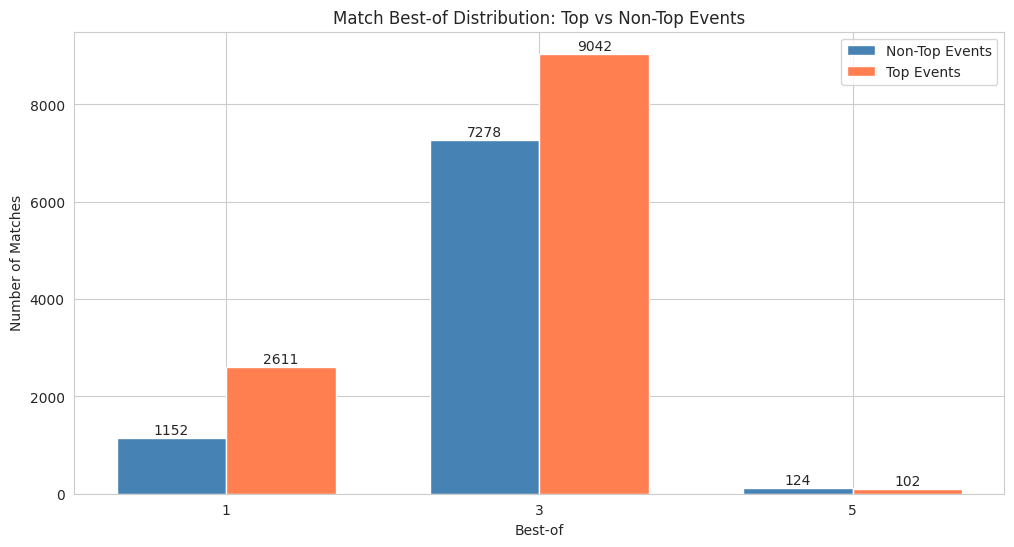

In [ ]:
non_top_events_best_of_dist = (
    non_top_event_vetos.lazy()
    .group_by("best_of")
    .agg(pl.len().alias("count"))
    .sort("best_of")
    .collect()
).to_pandas()

top_events_best_of_dist = (
    top_event_vetos.lazy()
    .group_by("best_of")
    .agg(pl.len().alias("count"))
    .sort("best_of")
    .collect()
).to_pandas()

fig, ax = plt.subplots()

width = 0.35
x = np.arange(len(non_top_events_best_of_dist))

bars1 = ax.bar(
    x - width / 2,
    non_top_events_best_of_dist["count"],
    width,
    label="Non-Top Events",
    color="steelblue",
)
bars2 = ax.bar(
    x + width / 2,
    top_events_best_of_dist["count"],
    width,
    label="Top Events",
    color="coral",
)

ax.set_title("Match Best-of Distribution: Top vs Non-Top Events")
ax.set_xlabel("Best-of")
ax.set_ylabel("Number of Matches")
ax.set_xticks(x)
ax.set_xticklabels(non_top_events_best_of_dist["best_of"])
ax.legend()

ax.bar_label(bars1)
ax.bar_label(bars2)

plt.show()


/tmp/ipykernel_413131/290888689.py:18: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("ban_count"))
/tmp/ipykernel_413131/290888689.py:40: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("ban_count"))


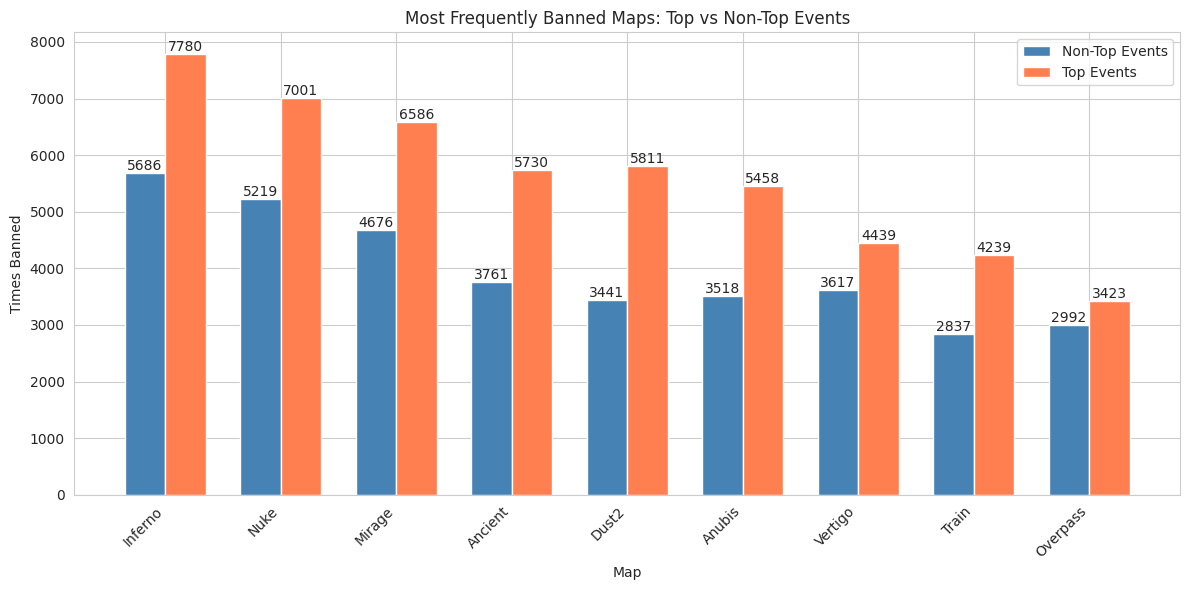

In [ ]:
all_bans = []
for col in [
    "t1_removed_1",
    "t2_removed_1",
    "t1_removed_2",
    "t2_removed_2",
    "t1_removed_3",
    "t2_removed_3",
]:
    if col in non_top_event_vetos.columns:
        bans = non_top_event_vetos.filter(
            (pl.col(col).is_not_null()) & (pl.col(col) != "Cache")
        ).select(pl.col(col).alias("map"))
        if len(bans) > 0:
            all_bans.append(bans)

all_bans_df = pl.concat(all_bans)
non_top_ban_counts = (
    all_bans_df.group_by("map").agg(pl.count().alias("ban_count")).sort("map")
).to_pandas()

# Top events bans
top_all_bans = []
for col in [
    "t1_removed_1",
    "t2_removed_1",
    "t1_removed_2",
    "t2_removed_2",
    "t1_removed_3",
    "t2_removed_3",
]:
    if col in top_event_vetos.columns:
        bans = top_event_vetos.filter(pl.col(col).is_not_null()).select(
            pl.col(col).alias("map")
        )
        if len(bans) > 0:
            top_all_bans.append(bans)

top_all_bans_df = pl.concat(top_all_bans)
top_ban_counts = (
    top_all_bans_df.group_by("map").agg(pl.count().alias("ban_count")).sort("map")
).to_pandas()

# Merge datasets
ban_comparison = non_top_ban_counts.merge(
    top_ban_counts, on="map", how="outer", suffixes=("_non_top", "_top")
).fillna(0)

# Sort by total bans
ban_comparison["total"] = (
    ban_comparison["ban_count_non_top"] + ban_comparison["ban_count_top"]
)
ban_comparison = ban_comparison.sort_values("total", ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
x = np.arange(len(ban_comparison))

bars1 = ax.bar(
    x - width / 2,
    ban_comparison["ban_count_non_top"],
    width,
    label="Non-Top Events",
    color="steelblue",
)
bars2 = ax.bar(
    x + width / 2,
    ban_comparison["ban_count_top"],
    width,
    label="Top Events",
    color="coral",
)

ax.set_xlabel("Map")
ax.set_ylabel("Times Banned")
ax.set_title("Most Frequently Banned Maps: Top vs Non-Top Events")
ax.set_xticks(x)
ax.set_xticklabels(ban_comparison["map"], rotation=45, ha="right")
ax.legend()

ax.bar_label(bars1)
ax.bar_label(bars2)

plt.tight_layout()
plt.show()


/tmp/ipykernel_413131/1841454721.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("pick_count"))
/tmp/ipykernel_413131/1841454721.py:47: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("pick_count"))


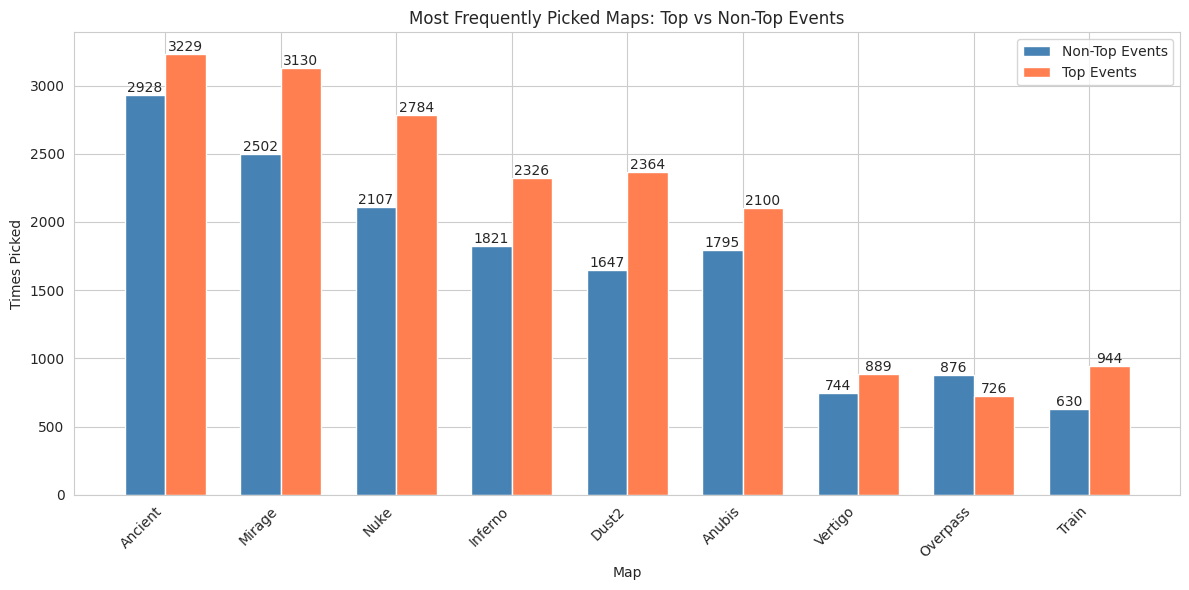

In [ ]:
# Non-top events picks
all_picks = []
for col in [
    "t1_picked_1",
    "t2_picked_1",
    "t1_picked_2",
    "t2_picked_2",
    "t1_picked_3",
    "t2_picked_3",
    "decider",
]:
    if col in non_top_event_vetos.columns:
        picks = non_top_event_vetos.filter(
            (pl.col(col).is_not_null()) & (pl.col(col) != "Cache")
        ).select(pl.col(col).alias("map"))
        if len(picks) > 0:
            all_picks.append(picks)

all_picks_df = pl.concat(all_picks)
non_top_pick_counts = (
    all_picks_df.group_by("map").agg(pl.count().alias("pick_count")).sort("map")
).to_pandas()

# Top events picks
top_all_picks = []
for col in [
    "t1_picked_1",
    "t2_picked_1",
    "t1_picked_2",
    "t2_picked_2",
    "t1_picked_3",
    "t2_picked_3",
    "decider",
]:
    if col in top_event_vetos.columns:
        picks = top_event_vetos.filter(
            (pl.col(col).is_not_null()) & (pl.col(col) != "Cache")
        ).select(pl.col(col).alias("map"))
        if len(picks) > 0:
            top_all_picks.append(picks)

top_all_picks_df = pl.concat(top_all_picks)
top_pick_counts = (
    top_all_picks_df.group_by("map").agg(pl.count().alias("pick_count")).sort("map")
).to_pandas()

# Merge datasets
pick_comparison = non_top_pick_counts.merge(
    top_pick_counts, on="map", how="outer", suffixes=("_non_top", "_top")
).fillna(0)

# Sort by total picks
pick_comparison["total"] = (
    pick_comparison["pick_count_non_top"] + pick_comparison["pick_count_top"]
)
pick_comparison = pick_comparison.sort_values("total", ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
x = np.arange(len(pick_comparison))

bars1 = ax.bar(
    x - width / 2,
    pick_comparison["pick_count_non_top"],
    width,
    label="Non-Top Events",
    color="steelblue",
)
bars2 = ax.bar(
    x + width / 2,
    pick_comparison["pick_count_top"],
    width,
    label="Top Events",
    color="coral",
)

ax.set_xlabel("Map")
ax.set_ylabel("Times Picked")
ax.set_title("Most Frequently Picked Maps: Top vs Non-Top Events")
ax.set_xticks(x)
ax.set_xticklabels(pick_comparison["map"], rotation=45, ha="right")
ax.legend()

ax.bar_label(bars1)
ax.bar_label(bars2)

plt.tight_layout()
plt.show()


/tmp/ipykernel_413131/1265531105.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("pick_count")


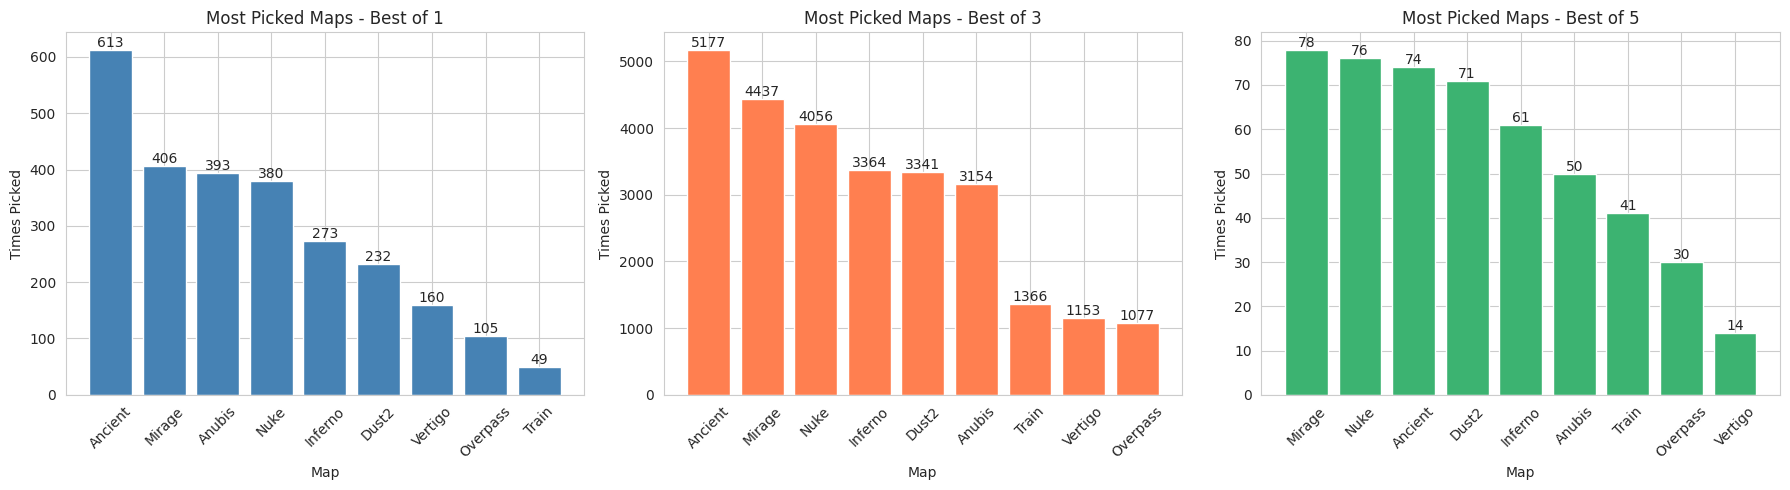

In [ ]:
def get_picks_by_best_of(vetos_df, best_of_value):
    """Get pick counts for a specific best_of format"""
    filtered = vetos_df.filter(pl.col("best_of") == best_of_value)

    all_picks = []
    for col in [
        "t1_picked_1",
        "t2_picked_1",
        "t1_picked_2",
        "t2_picked_2",
        "t1_picked_3",
        "t2_picked_3",
        "left_over_map",
    ]:
        if col in filtered.columns:
            picks = filtered.filter(
                (pl.col(col).is_not_null()) & (pl.col(col) != "Cache")
            ).select(pl.col(col).alias("map"))
            if len(picks) > 0:
                all_picks.append(picks)

    if not all_picks:
        return pl.DataFrame({"map": [], "pick_count": []})

    picks_df = pl.concat(all_picks)
    return (
        picks_df.group_by("map")
        .agg(pl.count().alias("pick_count"))
        .sort("pick_count", descending=True)
    )


# Get picks for different formats (top events only)
bo1_picks = get_picks_by_best_of(top_event_vetos, 1)
bo3_picks = get_picks_by_best_of(top_event_vetos, 3)
bo5_picks = get_picks_by_best_of(top_event_vetos, 5)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

bo1_data = bo1_picks.to_pandas()
axes[0].bar(bo1_data["map"], bo1_data["pick_count"], color="steelblue")
axes[0].set_title("Most Picked Maps - Best of 1")
axes[0].set_xlabel("Map")
axes[0].set_ylabel("Times Picked")
axes[0].tick_params(axis="x", rotation=45)
for i, (map_name, count) in enumerate(zip(bo1_data["map"], bo1_data["pick_count"])):
    axes[0].text(i, count, str(int(count)), ha="center", va="bottom")

bo3_data = bo3_picks.to_pandas()
axes[1].bar(bo3_data["map"], bo3_data["pick_count"], color="coral")
axes[1].set_title("Most Picked Maps - Best of 3")
axes[1].set_xlabel("Map")
axes[1].set_ylabel("Times Picked")
axes[1].tick_params(axis="x", rotation=45)
for i, (map_name, count) in enumerate(zip(bo3_data["map"], bo3_data["pick_count"])):
    axes[1].text(i, count, str(int(count)), ha="center", va="bottom")

bo5_data = bo5_picks.to_pandas()
axes[2].bar(bo5_data["map"], bo5_data["pick_count"], color="mediumseagreen")
axes[2].set_title("Most Picked Maps - Best of 5")
axes[2].set_xlabel("Map")
axes[2].set_ylabel("Times Picked")
axes[2].tick_params(axis="x", rotation=45)
for i, (map_name, count) in enumerate(zip(bo5_data["map"], bo5_data["pick_count"])):
    axes[2].text(i, count, str(int(count)), ha="center", va="bottom")

plt.tight_layout()
plt.show()


## Map Analysis


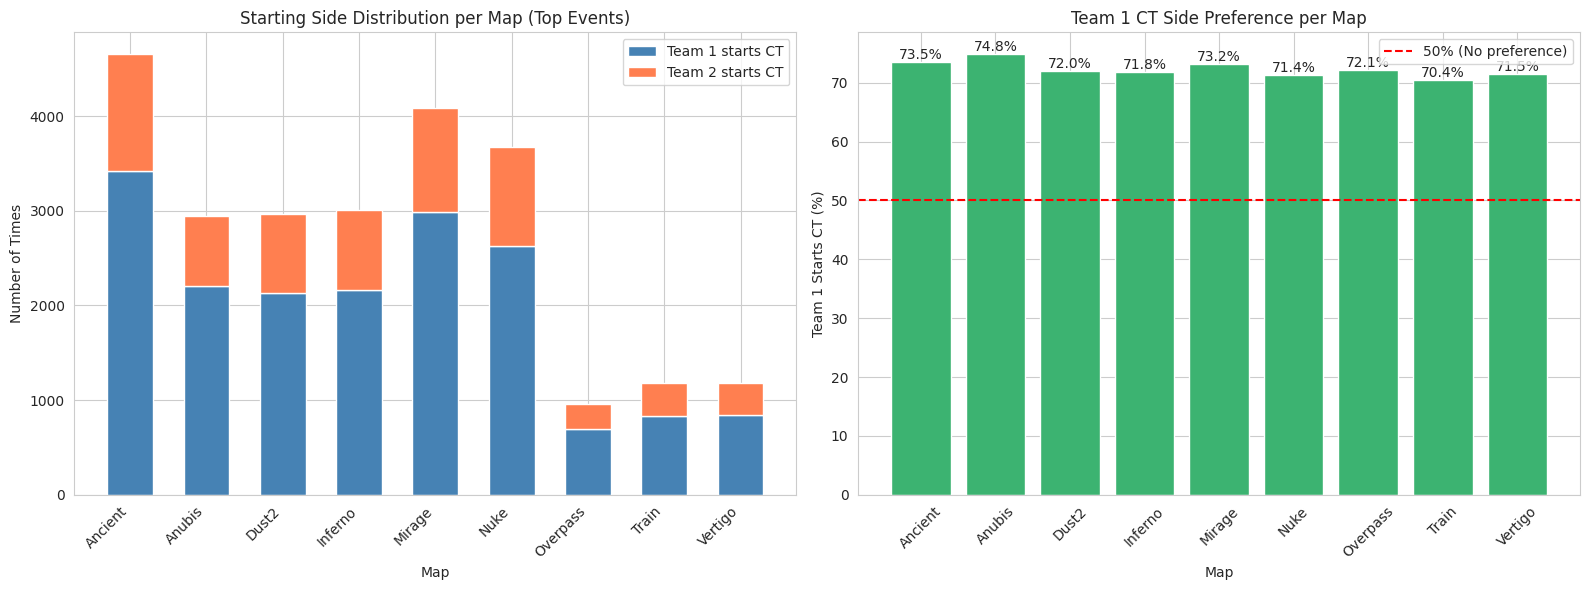

In [ ]:
# Analyze which side teams choose to start on for each map
picked_sides_per_map = (
    top_event_map_stats.filter(pl.col("map_name") != "Cache")
    .group_by("map_name", "starting_ct")
    .agg(pl.len().alias("count"))
    .sort("map_name", "starting_ct")
)

# Pivot to get CT and T starts side by side
side_comparison = picked_sides_per_map.pivot(
    on="starting_ct", index="map_name", values="count"
).fill_null(0)

# Get column names (they should be the team IDs)
cols = [c for c in side_comparison.columns if c != "map_name"]

col1, col2 = cols[0], cols[1]

side_comparison = side_comparison.with_columns(
    [
        (pl.col(col1) + pl.col(col2)).alias("total"),
        ((pl.col(col1) / (pl.col(col1) + pl.col(col2))) * 100).alias("team_1_ct_pct"),
    ]
).rename({col1: "team_1_ct", col2: "team_2_ct"})

# Visualize the side preferences
side_data = side_comparison.to_pandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
width = 0.6
x = np.arange(len(side_data))

bars1 = ax1.bar(
    x, side_data["team_1_ct"], width, label="Team 1 starts CT", color="steelblue"
)
bars2 = ax1.bar(
    x,
    side_data["team_2_ct"],
    width,
    bottom=side_data["team_1_ct"],
    label="Team 2 starts CT",
    color="coral",
)

ax1.set_xlabel("Map")
ax1.set_ylabel("Number of Times")
ax1.set_title("Starting Side Distribution per Map (Top Events)")
ax1.set_xticks(x)
ax1.set_xticklabels(side_data["map_name"], rotation=45, ha="right")
ax1.legend()

# Percentage chart showing Team 1 CT preference
bars = ax2.bar(
    side_data["map_name"], side_data["team_1_ct_pct"], color="mediumseagreen"
)
ax2.axhline(y=50, color="red", linestyle="--", label="50% (No preference)")
ax2.set_xlabel("Map")
ax2.set_ylabel("Team 1 Starts CT (%)")
ax2.set_title("Team 1 CT Side Preference per Map")
ax2.tick_params(axis="x", rotation=45)
ax2.legend()

# Add percentage labels
for i, (map_name, pct) in enumerate(
    zip(side_data["map_name"], side_data["team_1_ct_pct"])
):
    ax2.text(i, pct, f"{pct:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

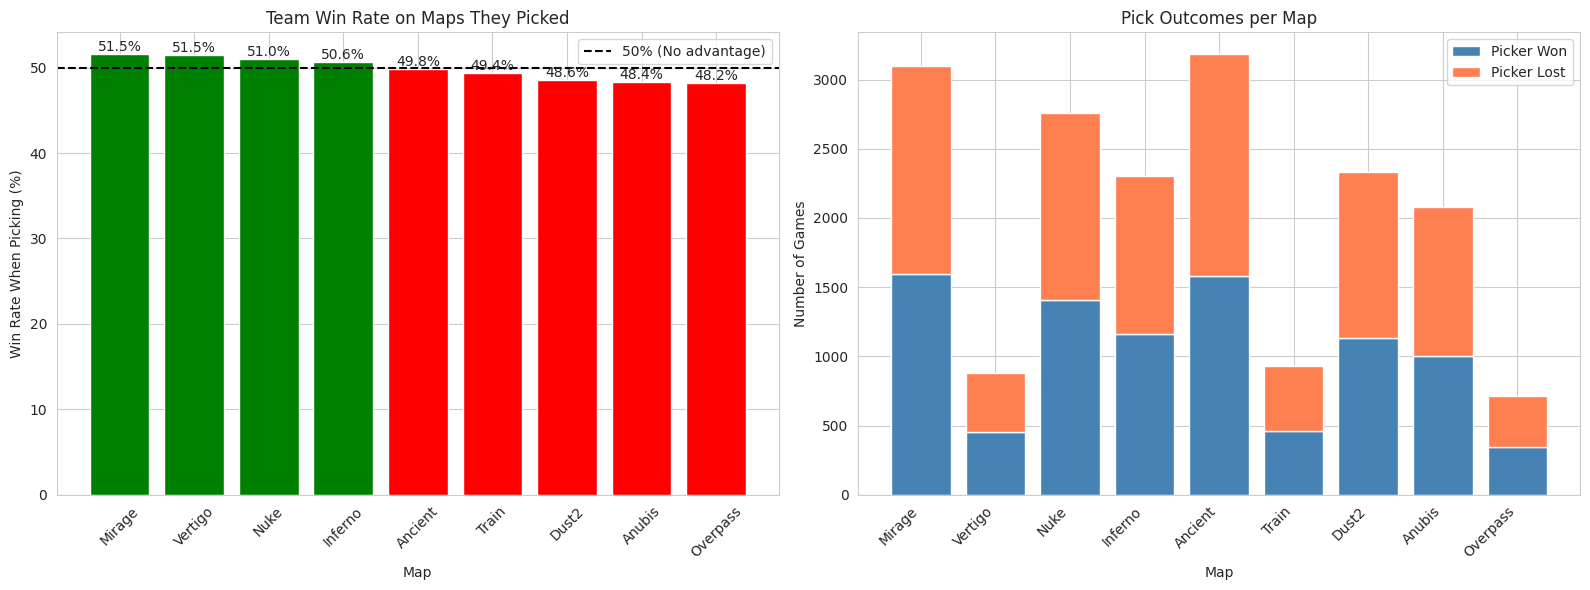

In [ ]:
# Analyze win rate when picking a map
def analyze_pick_win_correlation(vetos_df, map_stats_df, matches_df):
    """Analyze if teams that pick maps tend to win them"""

    # Join vetos with map_stats and matches to get team IDs and winner
    combined = (
        vetos_df.join(map_stats_df, on="match_id", how="inner")
        .join(
            matches_df.select(["match_id", "team_1_id", "team_2_id", "team_winner_id"]),
            on="match_id",
            how="inner",
        )
        .filter(pl.col("map_name") != "Cache")
    )

    results = []

    # Check team 1 picks
    for pick_col in ["t1_picked_1", "t1_picked_2", "t1_picked_3"]:
        if pick_col in combined.columns:
            team1_picks = combined.filter(
                pl.col(pick_col) == pl.col("map_name")
            ).select(
                [
                    pl.col("map_name"),
                    pl.col("team_1_id").alias("picker_id"),
                    pl.col("team_winner_id"),
                    (pl.col("team_1_id") == pl.col("team_winner_id")).alias(
                        "picker_won"
                    ),
                ]
            )
            if len(team1_picks) > 0:
                results.append(team1_picks)

    # Check team 2 picks
    for pick_col in ["t2_picked_1", "t2_picked_2", "t2_picked_3"]:
        if pick_col in combined.columns:
            team2_picks = combined.filter(
                pl.col(pick_col) == pl.col("map_name")
            ).select(
                [
                    pl.col("map_name"),
                    pl.col("team_2_id").alias("picker_id"),
                    pl.col("team_winner_id"),
                    (pl.col("team_2_id") == pl.col("team_winner_id")).alias(
                        "picker_won"
                    ),
                ]
            )
            if len(team2_picks) > 0:
                results.append(team2_picks)

    if not results:
        return None, None, None

    # Combine all picks
    all_picks = pl.concat(results)

    # Overall statistics
    overall_stats = all_picks.select(
        [
            pl.len().alias("total_picks"),
            pl.col("picker_won").sum().alias("picker_wins"),
            (pl.col("picker_won").sum() / pl.len() * 100).alias("picker_win_pct"),
        ]
    )

    # Per-map statistics
    per_map_stats = (
        all_picks.group_by("map_name")
        .agg(
            [
                pl.len().alias("times_picked"),
                pl.col("picker_won").sum().alias("picker_wins"),
                (pl.col("picker_won").sum() / pl.len() * 100).alias("picker_win_pct"),
            ]
        )
        .sort("picker_win_pct", descending=True)
    )

    return overall_stats, per_map_stats, all_picks


# Analyze for top events
overall, per_map, all_picks_data = analyze_pick_win_correlation(
    top_event_vetos, top_event_map_stats, top_events_matches
)


# Visualize
per_map_data = per_map.to_pandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of win percentages per map
colors = ["green" if x >= 50 else "red" for x in per_map_data["picker_win_pct"]]
bars = ax1.bar(per_map_data["map_name"], per_map_data["picker_win_pct"], color=colors)
ax1.axhline(y=50, color="black", linestyle="--", label="50% (No advantage)")
ax1.set_xlabel("Map")
ax1.set_ylabel("Win Rate When Picking (%)")
ax1.set_title("Team Win Rate on Maps They Picked")
ax1.tick_params(axis="x", rotation=45)
ax1.legend()

# Add percentage labels
for i, pct in enumerate(per_map_data["picker_win_pct"]):
    ax1.text(i, pct, f"{pct:.1f}%", ha="center", va="bottom")

# Stacked bar chart showing wins vs losses when picking
wins = per_map_data["picker_wins"]
losses = per_map_data["times_picked"] - per_map_data["picker_wins"]
x = np.arange(len(per_map_data))

bars1 = ax2.bar(x, wins, label="Picker Won", color="steelblue")
bars2 = ax2.bar(x, losses, bottom=wins, label="Picker Lost", color="coral")

ax2.set_xlabel("Map")
ax2.set_ylabel("Number of Games")
ax2.set_title("Pick Outcomes per Map")
ax2.set_xticks(x)
ax2.set_xticklabels(per_map_data["map_name"], rotation=45, ha="right")
ax2.legend()

plt.tight_layout()
plt.show()

## Player Stats Analysis


In [ ]:
from datetime import date

player_stats_with_names = (
    top_events_player_map_stats.join(players, on="player_id", how="left")
    .join(
        map_stats.select(["map_stat_id", "match_id", "map_name"]),
        on="map_stat_id",
        how="left",
    )
    .join(matches.select(["match_id", "match_date"]), on="match_id", how="left")
)

player_aggregate = (
    player_stats_with_names.group_by("player_id", "name")
    .agg(
        [
            pl.len().alias("maps_played"),
            # CT side stats
            pl.sum("kills_ct").alias("total_kills_ct"),
            pl.sum("deaths_ct").alias("total_deaths_ct"),
            pl.sum("assists_ct").alias("total_assists_ct"),
            pl.sum("clutches_ct").alias("total_clutches_ct"),
            pl.sum("opening_kills_ct").alias("total_opening_kills_ct"),
            pl.sum("opening_deaths_ct").alias("total_opening_deaths_ct"),
            pl.mean("rating_3_dot_0_ct").alias("avg_rating_ct"),
            pl.mean("adr_ct").alias("avg_adr_ct"),
            pl.mean("kast_ct").alias("avg_kast_ct"),
            # T side stats
            pl.sum("kills_tr").alias("total_kills_tr"),
            pl.sum("deaths_tr").alias("total_deaths_tr"),
            pl.sum("assists_tr").alias("total_assists_tr"),
            pl.sum("clutches_tr").alias("total_clutches_tr"),
            pl.sum("opening_kills_tr").alias("total_opening_kills_tr"),
            pl.sum("opening_deaths_tr").alias("total_opening_deaths_tr"),
            pl.mean("rating_3_dot_0_tr").alias("avg_rating_tr"),
            pl.mean("adr_tr").alias("avg_adr_tr"),
            pl.mean("kast_tr").alias("avg_kast_tr"),
        ]
    )
    .with_columns(
        [
            (pl.col("total_kills_ct") + pl.col("total_kills_tr")).alias("total_kills"),
            (pl.col("total_deaths_ct") + pl.col("total_deaths_tr")).alias(
                "total_deaths"
            ),
            (pl.col("total_clutches_ct") + pl.col("total_clutches_tr")).alias(
                "total_clutches"
            ),
            ((pl.col("avg_rating_ct") + pl.col("avg_rating_tr")) / 2).alias(
                "avg_rating_overall"
            ),
            ((pl.col("avg_adr_ct") + pl.col("avg_adr_tr")) / 2).alias(
                "avg_adr_overall"
            ),
        ]
    )
    .with_columns([(pl.col("total_kills") / pl.col("total_deaths")).alias("kd_ratio")])
    .sort("avg_rating_overall", descending=True)
)

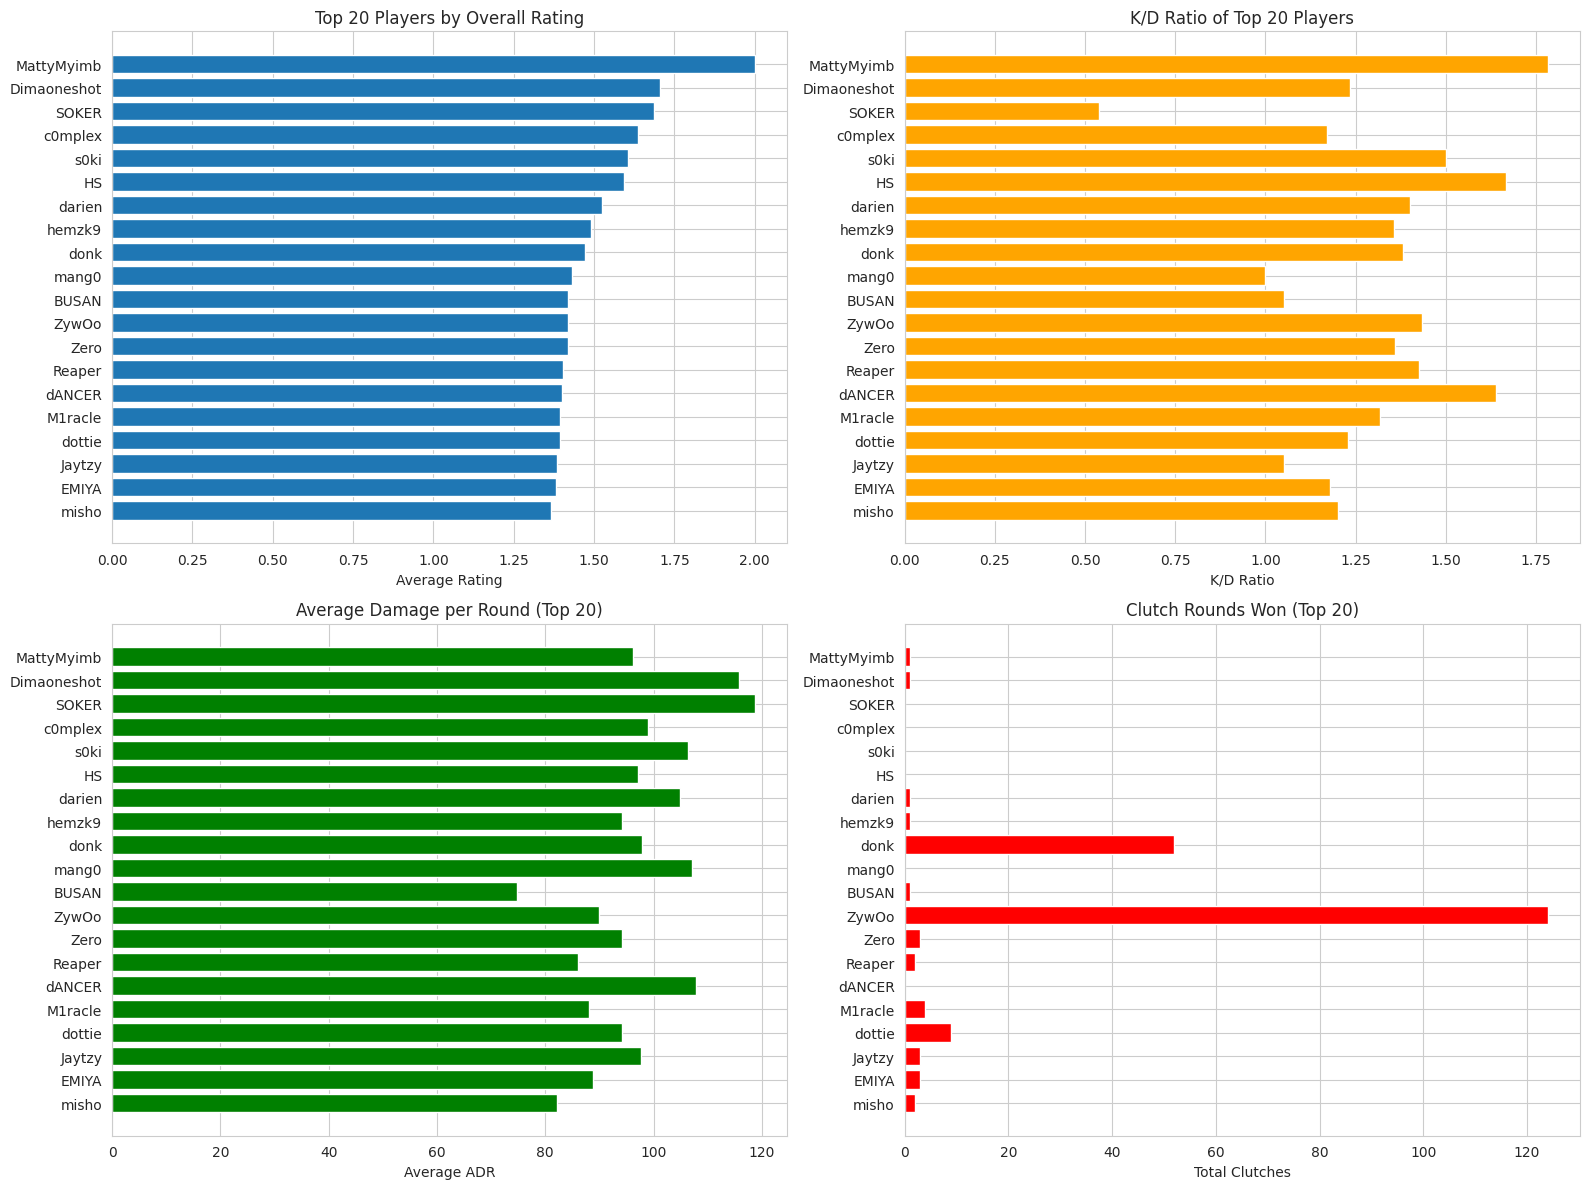

In [53]:
top_20 = player_aggregate.head(20).to_pandas()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Rating
axes[0, 0].barh(top_20["name"], top_20["avg_rating_overall"])
axes[0, 0].set_xlabel("Average Rating")
axes[0, 0].set_title("Top 20 Players by Overall Rating")
axes[0, 0].invert_yaxis()

# K/D Ratio
axes[0, 1].barh(top_20["name"], top_20["kd_ratio"], color="orange")
axes[0, 1].set_xlabel("K/D Ratio")
axes[0, 1].set_title("K/D Ratio of Top 20 Players")
axes[0, 1].invert_yaxis()

# ADR
axes[1, 0].barh(top_20["name"], top_20["avg_adr_overall"], color="green")
axes[1, 0].set_xlabel("Average ADR")
axes[1, 0].set_title("Average Damage per Round (Top 20)")
axes[1, 0].invert_yaxis()

# Clutches
axes[1, 1].barh(top_20["name"], top_20["total_clutches"], color="red")
axes[1, 1].set_xlabel("Total Clutches")
axes[1, 1].set_title("Clutch Rounds Won (Top 20)")
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

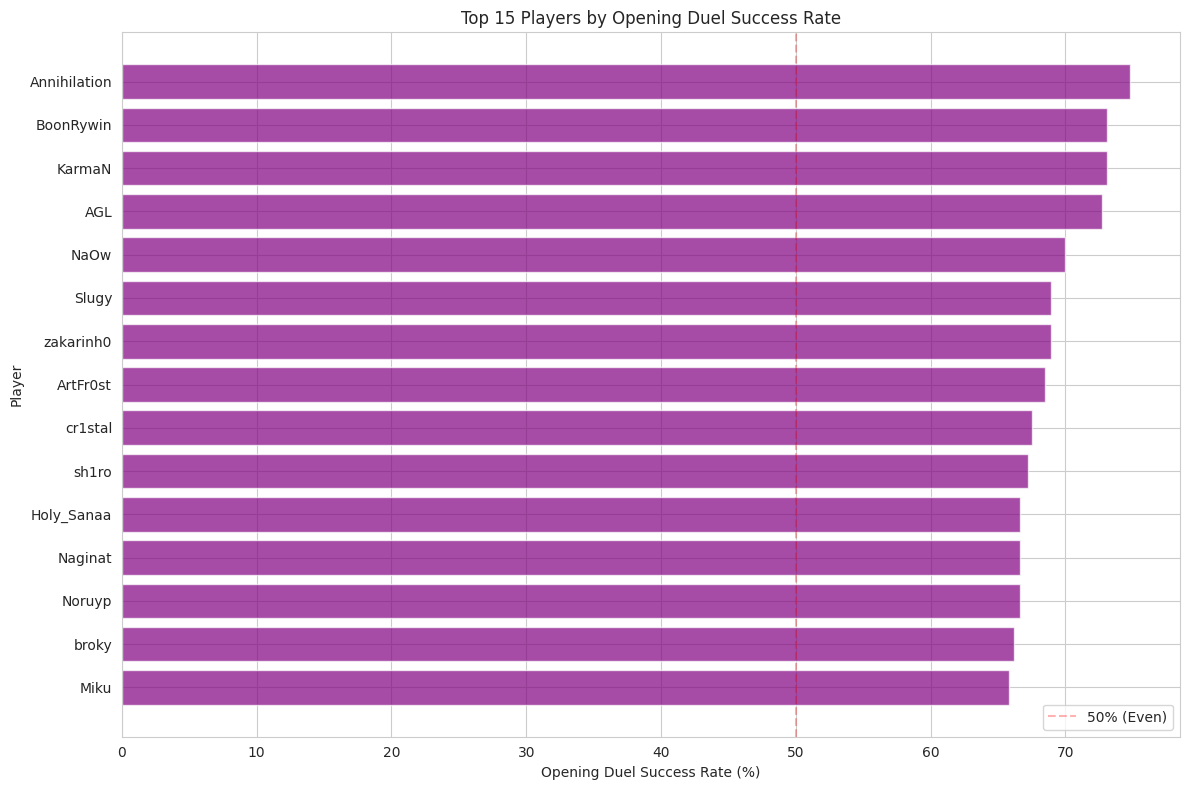

In [50]:
opening_duels = (
    player_aggregate.with_columns(
        [
            (pl.col("total_opening_kills_ct") + pl.col("total_opening_kills_tr")).alias(
                "total_opening_kills"
            ),
            (
                pl.col("total_opening_deaths_ct") + pl.col("total_opening_deaths_tr")
            ).alias("total_opening_deaths"),
        ]
    )
    .with_columns(
        [
            (
                pl.col("total_opening_kills")
                / (pl.col("total_opening_kills") + pl.col("total_opening_deaths"))
            ).alias("opening_success_rate")
        ]
    )
    .filter(
        (pl.col("total_opening_kills") + pl.col("total_opening_deaths"))
        >= 20  # At least 20 opening duels
    )
    .sort("opening_success_rate", descending=True)
)

# Visualize
opening_top15 = opening_duels.head(15).to_pandas()
plt.figure(figsize=(12, 8))
plt.barh(
    opening_top15["name"],
    opening_top15["opening_success_rate"] * 100,
    color="purple",
    alpha=0.7,
)
plt.xlabel("Opening Duel Success Rate (%)")
plt.ylabel("Player")
plt.title("Top 15 Players by Opening Duel Success Rate")
plt.axvline(x=50, color="r", linestyle="--", alpha=0.3, label="50% (Even)")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()